In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 13px;
}

div.output_picture pre {
    font-size: 13px;
}
</style>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from wordcloud import WordCloud, STOPWORDS
import urllib.request
from PIL import Image
import re 
import seaborn as sns
import matplotlib.colors
import plotly.io as pio
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
import plotly.express as px
import matplotlib.colors

from ipywidgets import Layout, Label, HBox, VBox, HTML
from IPython.display import display, clear_output
import IPython

### Phân tích EDA

In [3]:
# Tên các sheet trong file saved_file.xlsx
name_sheet = ["ID","DATA","RATING"]

In [4]:
#Lấy dữ liệu
data_ID = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[0])
data_DATA = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[1])
data_RATING = pd.read_excel('saved_file.xlsx',sheet_name=name_sheet[2])
data_LOC = pd.read_excel('Tinh_VN.xlsx')

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 75

Màu chủ đạo

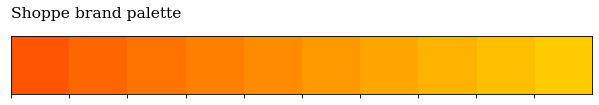

In [6]:
sns.palplot(['#FF5500','#FF6600','#FF7300','#FF8000','#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFCC00'])
    #['#FF5E00','#FF6347','#FF7F50','#FF8C00','#FF9933','#FFA500','#FFCC00','#FFD700','#FFFFE0',])
plt.title("Shoppe brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [7]:
colors = ['#FF5500','#FF6600','#FF7300','#FF8000','#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFCC00']
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
color_list = ['#FF8C00','#FF9933', '#FFA500','#FFCC00', '#FFD700','#FFFFE0','#8fcc52','#70cc52','#52cc52','#52cc70',
             '#52cc8f','#52ccad','#52cccc','#52adcc','#528fcc','#5270cc','#5252cc','#7052cc','#8f52cc','#ad52cc',
              '#cc52cc']

## DATA

In [8]:
list_name = ['Doanh số', 'Tồn kho',#'Giá gốc', 'Khuyến mãi %', 'Giá sau khuyến mãi',
             'Doanh thu', 'Lượt thích', 'Đánh giá', 'Lượt đánh giá']
list_sort = ['Cao nhất', 'Thấp nhất']
# Phân bố dữ liệu các cột trong DATA (ci_95,max,min,mode,mean)
@widgets.interact(Mục_tiêu = list_name, Khoảng_tin_cậy_95 = True )
def Phan_bo(Mục_tiêu='Doanh số', Khoảng_tin_cậy_95 = True):
    if Khoảng_tin_cậy_95 == True:
        data = np.array(data_DATA[Mục_tiêu])
        ci_95 = np.percentile(data,[2.5,97.5])
        thongtin = np.delete(data,data<ci_95[0])
        data =  np.delete(data,data>ci_95[1])
    else:
        data = np.array(data_DATA[Mục_tiêu])
       
    def thong_tin(thongtin, h , k , name , col):
        plt.axvline(thongtin, color = col, linestyle = "--", linewidth=0.5)
        plt.text(thongtin, h*k, f'{name}: {thongtin:0,.2f}',color=col,weight="bold")
        
    n, bins, patches = plt.hist(data, bins=50,color="orange")
    mode_idx = np.argmax(n)
    mode_data = bins[mode_idx]
    thong_tin(mode_data, n[mode_idx], 1, "Mode", "y") 
    thong_tin(np.min(data), n[mode_idx], 0.85, "Min", colors[-1])
    thong_tin(np.max(data), n[mode_idx], 0.7, "Max", colors[0])
    thong_tin(np.median(data), n[mode_idx], 0.55, "Median", "b")
    thong_tin(np.mean(data), n[mode_idx], 0.4, "Mean", "g")
    plt.title(f"Phân bố dữ liệu các cột {Mục_tiêu}\ntrong bảng dữ liệu DATA", fontsize=16, fontweight="bold", color=colors[0])
    plt.xlabel(f"{Mục_tiêu}", fontsize=14, color="k")
    plt.ylabel("Số lần xuất hiện", fontsize=14, color="k")
    #plt.grid()
    plt.show()

interactive(children=(Dropdown(description='Mục_tiêu', options=('Doanh số', 'Tồn kho', 'Doanh thu', 'Lượt thíc…

### Top 10 Sản Phẩm có Số Lượng bán, Tồn kho, Giá gốc, % Khuyến mãi, Giá sau khuyến mãi, Doanh thu, lượt thích, đánh giá, Số lượt đánh giá cao nhất, thấp nhất kèm theo hình ảnh

In [9]:
# Tạo hàm
def Sua_ten(text):
    x = text.split(' ')
    for i in range(12,len(x),12):
        x[i] = x[i]+"\n" 
    text = ' '.join(x) 
    return text

@widgets.interact(Top = (5,10,1), Mục_tiêu = list_name, Sắp_xếp = list_sort, Hình_ảnh = True)
def Top_Hinh_anh(Top =5, Mục_tiêu ='Doanh số', Sắp_xếp = 'Cao nhất',  Hình_ảnh = True):
    if Sắp_xếp == 'Cao nhất':
        top5_id = data_DATA[['item_id',Mục_tiêu,'product_image_link']].nlargest(Top, columns = Mục_tiêu)
        data_thong_tin = data_DATA[['item_id',Mục_tiêu,'Giá gốc', 'Khuyến mãi %', 'Giá khuyến mãi']].nlargest(Top, columns = Mục_tiêu)
    else:
        top5_id = data_DATA[['item_id',Mục_tiêu,'product_image_link']].nsmallest(Top, columns = Mục_tiêu)
        data_thong_tin = data_DATA[['item_id',Mục_tiêu,'Giá gốc', 'Khuyến mãi %', 'Giá khuyến mãi']].nsmallest(Top, columns = Mục_tiêu)
    
    top5_name = pd.merge(top5_id, data_ID[["item_id","Tên"]], on="item_id")
    top5_name['Tên'] = top5_name['Tên'].apply(Sua_ten)
    data_thong_tin_1 = data_thong_tin.reset_index()
    fig1 = px.bar(top5_name, x='Tên', y = Mục_tiêu, 
                 width=800, height=400,
                 #color="Tên",
                 color_discrete_sequence=colors[3:4],
                 hover_name = "Tên",
                 text_auto=True,) 
    for idx in range(len(fig1.data)):
        list_i = []
        for i in range(1,Top+1):
            a = str(i)
            list_i.append(a)
        fig1.data[idx].x = list_i     
    fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig1.update_layout(title=f"Top 5 sản phẩm có {Mục_tiêu.lower()} {Sắp_xếp.lower()}",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title=f"Top {Top} sản phẩm",
                     )
    fig1.show()
    
    if  Hình_ảnh == True:
        for i in range(Top):
            urllib.request.urlretrieve(top5_name['product_image_link'][i],f"hinh{i}.png")  
            img = Image.open(f"hinh{i}.png")
            name = top5_name['Tên'][i].title()
            fig = plt.figure(figsize=(3, 3))
            ax1 = fig.add_subplot(1, 1, 1)
            ax1.set_title(
            f'''Top {i+1}: {name}
            Giá gốc: {data_thong_tin_1['Giá gốc'][i]:0,}
            Khuyến mãi: {(data_thong_tin_1['Khuyến mãi %'][i]*100):.0f} %
            Giá khuyến mãi: {data_thong_tin_1['Giá khuyến mãi'][i]:0,.0f}''',
            fontsize=12, color=colors[0],
            weight='bold'
            )
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.imshow(img) 
    else: 
        print("Tick vào 'Hình_ảnh' để xem hình ảnh các sản phẩm")

interactive(children=(IntSlider(value=5, description='Top', max=10, min=5), Dropdown(description='Mục_tiêu', o…

### Số lượng cửa hàng tại các tỉnh, Khu vực

In [10]:
# Tạo bảng tổng hợp dữ liệu
data_1 = data_DATA[['shop_id','Doanh số','Doanh thu','Tồn kho']]
data_2 = data_1.groupby('shop_id').sum()
data_3 = data_2.reset_index()
data_4 = data_ID[["shop_id","Tỉnh"]].drop_duplicates() 
data_5 = pd.merge(data_3, data_4 , how = 'left',on = "shop_id")   
data_6 = data_5.astype({'shop_id':str})
data_7 = pd.merge(data_6, data_LOC, how = 'left',on = "Tỉnh")  

In [11]:
data_8 = data_7[['Khu Vực','Tỉnh','shop_id']].groupby(['Khu Vực','Tỉnh']).count()
data_9 = data_8.reset_index()
data_9 = data_9.rename(columns = {"shop_id":"Số lượng shop"})
#fig = px.bar(data_9, x='Khu Vực', y='Số lượng shop', #color='Tỉnh',
fig = px.sunburst(data_9, path=["Khu Vực",'Tỉnh'], values='Số lượng shop',color='Số lượng shop',
                  color_continuous_scale=colors[::-4],range_color=[0,300],
                  labels={'labels':"Tên","Số lượng shop_sum":'Tổng số shop'},
                  width=500, height=500,
                 )  
fig.update_layout(title="Số lượng cửa hàng tại các tỉnh, khu vực",
                   title_font_color='orange',
                   title_font_size=20,
                   title_font_family="Times New Roman",
                  )
fig.update_layout(margin = dict(t=50, l=10, r=10, b=25))
fig.update_traces(textinfo='value+label',
                  hoverinfo='value+label',
                  hovertemplate ="%{label} <br>Số lượng shop: %{value}",
                  textfont_size=13,
                 )
fig.show()

### Số lượng mặt hàng của các thương hiệu

In [12]:
data_brand = data_DATA['brand'].value_counts()

fig = px.pie(values=data_brand.values, names=data_brand.index,
             #color_discrete_sequence=px.colors.sequential.Oranges,
             width=500, height=500,
             #labels={'labels':"Tên","Số lượng shop_sum":'Tổng số shop'},
            )    
fig.update_layout(title="Số lượng sản phẩm của các thương hiệu",
                  title_font_color='orange',
                  title_font_size=20,
                  title_font_family="Times New Roman",
                 )
fig.update_layout(margin = dict(t=50, l=0, r=0, b=25))
fig.update_traces(textposition='inside', textinfo='label+value+percent', hoverinfo='label+value+percent',
                  hovertemplate ="%{label} <br>Số lượng mặt hàng: %{value}",
                  #textfont_size=10,
                  marker=dict(colors=colors[1::2]))
fig.show()

### Sử dụng interact Top 5-10 Shop_id có Doanh số, Tồn kho, Doanh thu cao nhất, thấp nhất

In [13]:
# Sử dụng interact Top 5-10 Shop_id có Số Lượng bán, Tồn kho, Doanh thu cao nhất, thấp nhất
list_name_shop = ['Doanh số','Doanh thu','Tồn kho']
list_sort_shop = ['Cao nhất', 'Thấp nhất']
@widgets.interact(Top = (5,10,1), Mục_tiêu = list_name_shop, Sắp_xếp = list_sort_shop)

def Top_shop(Top =5, Mục_tiêu='Doanh số', Sắp_xếp = 'Cao nhất'):
    data_shop = data_DATA[['shop_id','Doanh số','Doanh thu','Tồn kho']]     
    if Sắp_xếp == 'Cao nhất':        
        data_shop_1 = data_shop.groupby('shop_id').sum().nlargest(Top, columns = Mục_tiêu)
    else:        
        data_shop_1 = data_shop.groupby('shop_id').sum().nsmallest(Top, columns = Mục_tiêu)    
    data_shop_2 = data_shop_1.reset_index()     
    abc = data_ID[["shop_id","Tỉnh"]].drop_duplicates()    
    data_shop_3 = pd.merge(data_shop_2, abc, how = 'left',on = "shop_id")   
    data_shop_4 = data_shop_3.astype({'shop_id':str})
    
#     fig = go.Figure(data=[go.Bar(
#             x= data_shop_4['shop_id'], y = data_shop_4[Lists],
#             text=data_shop_4['Tỉnh'],
#             textposition='auto',
#         )])      
    fig = px.bar(data_shop_4, x='shop_id', y=Mục_tiêu, color="Tỉnh",
                 width=900, height=500,
                color_discrete_sequence=colors[::3],text_auto=True,
                text = "Tỉnh",
                ) 
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig.update_layout(title=f"Top {Top} shop có {Mục_tiêu.lower()} {Sắp_xếp.lower()}",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title="Shop ID",
                      yaxis_title= Mục_tiêu,
#                       legend=dict(
#                       x=0,
#                       y=1.0,
#                       bgcolor='rgba(255, 255, 255, 0)',
#                       bordercolor='rgba(255, 255, 255, 0)')
                     )
    fig.show()  

interactive(children=(IntSlider(value=5, description='Top', max=10, min=5), Dropdown(description='Mục_tiêu', o…

## Treemap

### Treemap Doanh thu theo Thương hiệu?

In [14]:
# list_name = ['Doanh số', 'Tồn kho','Doanh thu (Tỷ VNĐ)', 'Lượt thích', 'Lượt đánh giá']
# @widgets.interact(N = (10,20,1), List=list_name)
# def Doanh_thu_theo_thuong_hieu(N=15, List='Doanh thu (Tỷ VNĐ)'):
#     data_DATA['Doanh thu (Tỷ VNĐ)'] = data_DATA['Doanh thu']/1000000000
#     df_test = data_DATA[['brand',List]]
#     df_1 = df_test.groupby('brand').sum()
#     df_2 = df_1.nlargest(N, columns = List)
#     fig = plt.figure(figsize=(14,8))
#     fig = go.Figure()
#     fig.add_trace(go.Treemap(
#         values = df_2[List],
#         labels = df_2.index,
#         parents = [""]*len(df_2),
#         maxdepth=3,
#         marker_colors = colors, 
#         textinfo = "label+value+percent parent",
#         textposition='middle center',
#         textfont_size=13   
#     ))
#     fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
#     fig.update_layout(title=f"{List} theo Thương hiệu",
#                       title_font_color='orange',
#                       title_font_size=20,
#                       title_font_family="Times New Roman",
#                      )
#     fig.show()

In [15]:
data_brand_1 = pd.merge(data_DATA[['item_id','brand','Doanh số','Tồn kho',
                                   'Giá khuyến mãi','Doanh thu','Lượt thích','Lượt đánh giá']],
                        data_ID[['item_id','Tên']], on="item_id")
data_brand_2 = data_brand_1.drop("item_id",axis=1)
data_brand_3 = data_brand_2.groupby(['brand',"Tên"]).sum()
data_brand_4 = data_brand_3.reset_index()
data_brand_4['all'] = "all"
data_brand_4['Doanh thu (Tỷ VNĐ)'] = data_brand_4['Doanh thu']/1000000000

list_name = ['Doanh số', 'Tồn kho','Doanh thu (Tỷ VNĐ)', 'Lượt thích', 'Lượt đánh giá']
list_color = ['#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFCC00','#FADB41','#FAE741','#FFFFFF','#FFDA1F']
list_1 = ['#FF6600','#FF7300','#FF8000','#FF8C00','#FF9900','#FFA600','#FFB300','#FFBF00','#FFFFFF','#FFCC00']
@widgets.interact(Mục_tiêu=list_name)
def Doanh_thu_theo_thuong_hieu_1(Mục_tiêu='Doanh thu (Tỷ VNĐ)'):
    fig = px.treemap(data_brand_4, path=['all', 'brand', 'Tên'], values=Mục_tiêu, color='brand',color_discrete_sequence = list_1,
                     maxdepth=2
                    )
    fig.update_traces(textinfo = "label+value+percent parent",
                      textposition='middle center',
                      textfont_size=14,
                      hovertemplate ="%{label} <br>%{value}"
                     )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.update_layout(title=f"{Mục_tiêu} theo thương hiệu",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                     )
    fig.show()

interactive(children=(Dropdown(description='Mục_tiêu', index=2, options=('Doanh số', 'Tồn kho', 'Doanh thu (Tỷ…

In [16]:
data_KV_1 = data_ID[['item_id','Tỉnh','Tên']]
data_KV_2 = data_DATA[["item_id",'shop_id','Doanh số','Tồn kho','Doanh thu','Lượt thích','Lượt đánh giá']]
data_KV_3 = pd.merge(data_KV_1 , data_KV_2 ,on = "item_id")  
data_KV_4 = pd.merge(data_KV_3 ,data_LOC[['Khu Vực','Tỉnh']] ,on = "Tỉnh")
data_KV_5 = data_KV_4.drop("item_id",axis=1)
data_KV_6 = data_KV_5.groupby(['Khu Vực','Tỉnh',"Tên"]).sum()
data_KV_7 = data_KV_6.reset_index()
data_KV_7['all'] = "all"
data_KV_7['Doanh thu (Tỷ VNĐ)'] = data_KV_7['Doanh thu']/1000000000
list_name = ['Doanh số', 'Tồn kho','Doanh thu (Tỷ VNĐ)', 'Lượt thích', 'Lượt đánh giá']
list_color = ['#FF8C00','#FFA600','#FFBF00','#FFFFFF',]

@widgets.interact(Mục_tiêu=list_name)
def Doanh_thu_theo_thuong_hieu_1(Mục_tiêu='Doanh thu (Tỷ VNĐ)'):
    fig = px.treemap(data_KV_7, path=['all','Tỉnh','shop_id', "Tên"], values=Mục_tiêu, color='Khu Vực',
                     color_discrete_sequence = list_color,
                     maxdepth=2)
    fig.update_traces(textinfo = "label+value+percent parent",
                      textposition='middle center',
                      textfont_size=14,
                      hovertemplate ="%{label} <br>%{value}"
                     )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.update_layout(title=f"{Mục_tiêu} theo Tỉnh",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                     )
    fig.show()

interactive(children=(Dropdown(description='Mục_tiêu', index=2, options=('Doanh số', 'Tồn kho', 'Doanh thu (Tỷ…

### Bảng đồ doanh số giữa các khu vực ? 

In [17]:
# list_KV = ['Miền Bắc','Miền Trung','Miền Nam', 'Cả nước']
# list_name = ['Doanh số', 'Tồn kho','Doanh thu (Tỷ VNĐ)', 'Lượt thích', 'Lượt đánh giá']
# @widgets.interact(N = (10,20,1), KV=list_KV, Lists = list_name)
# def Doanh_thu_theo_tinh(N=15, KV='Cả nước', Lists='Doanh số'):
#     if KV == 'Cả nước':
#         df_1 = data_Map_5.sort_values(Lists, ascending=False)
#         df_2 = df_1[['Tỉnh', Lists]][0:N]
#         other_count = df_1[Lists][N:].sum()
#         other = pd.DataFrame({'Tỉnh': ['Khác'], Lists: [other_count]})
#         df_3 = pd.concat([df_2, other],ignore_index=True)
#     else:
#         df_1 = data_Map_5[data_Map_5['Khu Vực']==KV].sort_values(Lists, ascending=False)
#         df_2 = df_1[['Tỉnh', Lists]][0:N]
#         other_count = df_1[Lists][N:].sum()
#         other = pd.DataFrame({'Tỉnh': ['Khác'], Lists: [other_count]})
#         df_3 = pd.concat([df_2, other],ignore_index=True)
    
#     fig = plt.figure(figsize=(14,8))
#     fig = go.Figure()
#     fig.add_trace(go.Treemap(
#         values = df_3[Lists],
#         labels = df_3["Tỉnh"],
#         parents = [""]*len(df_3),
#         maxdepth=3,
#         marker_colors = colors ,
#         textinfo = "label+value+percent parent",
#         textposition='middle center',
#         textfont_size=14  
#     ))    
#     fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
#     fig.update_layout(title=f"<b>{Lists} của các Tỉnh trong {KV}</b>",
#                       title_font_color='orange',
#                       title_font_size=20,
#                       title_font_family="Times New Roman",
#                      )
#     fig.show()

In [18]:
data_Map_1 = data_ID[['item_id','Tỉnh']]
data_Map_2 = data_DATA[["item_id",'shop_id','Doanh số','Tồn kho','Doanh thu','Lượt thích','Lượt đánh giá']]
data_Map_3 = pd.merge(data_Map_1 , data_Map_2 ,on = "item_id")  
data_Map_4 = data_Map_3.groupby('Tỉnh').sum()
data_Map_5 = pd.merge(data_Map_4 ,data_LOC ,on = "Tỉnh")
list_name = ['Doanh số', 'Tồn kho','Doanh thu', 'Lượt thích', 'Lượt đánh giá']
data_Map_5['Doanh thu (Tỷ VNĐ)'] = data_Map_5['Doanh thu']/1000000000

@widgets.interact(Mục_tiêu = list_name)
def Ve_heat_map(Mục_tiêu='Doanh số'):
    heatMap_data = list(zip(data_Map_5['latitude'], data_Map_5['longitude'], data_Map_5[Mục_tiêu]))
    f_Figure = folium.Figure(width=900, height=500)
    f_Map    = folium.Map(location = (16.047079, 108.2062303), 
                          zoom_start=5,
                         ).add_to(f_Figure)
    f_heatMap = HeatMap(data = heatMap_data,
                         min_opacity=0.6,
                         # max_val = 120,
                         radius = 20,
                         overlay = True
                        ).add_to(f_Map)
    display(f_Map)

interactive(children=(Dropdown(description='Mục_tiêu', options=('Doanh số', 'Tồn kho', 'Doanh thu', 'Lượt thíc…

In [19]:
import json
with open('vietnam.geojson',encoding="utf-8") as file:
    Viet_Nam = json.load(file)
# Đổi tên Thừa Thiên - Huế => Thừa Thiên Huế, Hồ Chí Minh city = TP. Hồ Chí Minh
def Doi_ten(text):
    text = text.replace("TP. Hồ Chí Minh","Hồ Chí Minh city")
    text = text.replace("Thừa Thiên Huế","Thừa Thiên - Huế")
    return text
data_Map_6 = data_Map_5.copy()
data_Map_6['Tỉnh mới'] = data_Map_6['Tỉnh'].apply(Doi_ten)

@widgets.interact(Mục_tiêu = list_name)
def Ve_heat_map(Mục_tiêu='Doanh số'):
    fig_map = px.choropleth_mapbox(data_Map_6, geojson=Viet_Nam, color=Mục_tiêu,
                               locations="Tỉnh mới", featureidkey="properties.name",
                               center={"lat": 16.047079, "lon": 108.2062303}, 
                               mapbox_style="carto-positron", zoom=4.5,
                               color_continuous_scale=colors[::-1],
                               labels={'Tỉnh mới':'Tỉnh'},  )  
    #fig_map.update_traces(colorbar = 'southoutside')
#     fig_map.update_layout(coloraxis_colorbar=dict(
#         title="<b>Doanh số</b>",
#         title_font_color='#FF5500',
#         title_font_size=14,
#         title_font_family="Arial",
#         thicknessmode="pixels", 
#         thickness=10,
#         lenmode="pixels", 
#         len=300,
#         #yanchor="top",
#         y=1,
#         #ticks="outside", 
#         #ticksuffix=" bills",
#         orientation="h",
#         titleside = 'top',
#      ))
    #fig_map.update_layout(coloraxis_showscale=False)
    fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig_map.show()

interactive(children=(Dropdown(description='Mục_tiêu', options=('Doanh số', 'Tồn kho', 'Doanh thu', 'Lượt thíc…

## RATING

### Số lượng comment đánh 5,4,3,2,1 sao

In [20]:
rating_star_vote = data_RATING['rating_star'].value_counts()
fig = px.pie(names = rating_star_vote.index, 
             values = rating_star_vote.values,
             width=400, height=400,
             labels={'x':"Đánh giá",'y':"Số lượng đánh giá",'color':""},
            )
fig.update_layout(title="Số lượng bình luận đánh 5,4,3,2,1 sao",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title="Đánh giá",
                      yaxis_title="Số lượt đánh giá ",
                     )
fig.update_layout(margin = dict(t=50, l=0, r=0, b=25))
fig.update_traces(textposition='auto',
    textinfo='percent+value', hoverinfo='label+percent',
                  hovertemplate ="Đánh giá %{label} sao <br>Số lượng đánh giá: %{value}",
                  textfont_size=13,rotation=180,
                  marker=dict(colors=colors[1::2]))
fig.show()

### Top 5 khách hàng nhiều tương tác nhất

In [21]:
data_cus_1 = data_RATING[['item_id','user_name']]
data_cus_2 = data_DATA[['item_id','brand']]
data_cus_3 = pd.merge(data_cus_1, data_cus_2, on="item_id")
data_cus_4 = data_cus_3.groupby(['user_name',"brand"]).count()

data_cus_5 = data_cus_1[['user_name','item_id']].groupby("user_name").count()
data_cus_6 = data_cus_5.nlargest(5, columns = 'item_id')
data_cus_7 =  data_cus_6.reset_index()
data_cus_8 = data_cus_7.rename(columns = {'item_id':'count',})
data_cus_5 = data_cus_4.reset_index()
data_cus_9 = pd.merge(data_cus_8, data_cus_5, on="user_name",how="left")
fig1 = px.bar(data_cus_9, x="user_name", y="item_id", #color="brand",
             width=900, height=500,
              color_discrete_sequence=colors[2::2],
              labels={'item_id':"Số sản phẩm",'brand':"Thương hiệu",'user_name':"Tên người dùng"},
              #text_auto=True,
             )
fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig1.update_layout(title="Top 5 khách hàng mua hàng nhiều nhất",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title="ID khách hàng",
                      yaxis_title=" Số sản phẩm",)                    
fig1.show()

### Số lần được đánh giá của 1 sản phẩm

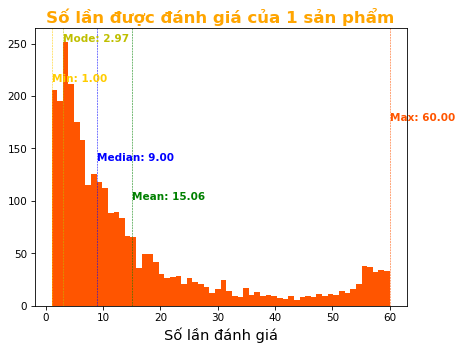

In [22]:
# Bỏ những đánh giá không có cmt
hist_cmt_1 = data_RATING.copy()
hist_cmt_1.dropna(inplace=True, axis=0, how="any")
hist_cmt_2 = hist_cmt_1["item_id"].value_counts()
n, bins, patches = plt.hist(hist_cmt_2.values, bins=60,color=colors[0])
plt.title("Số lần được đánh giá của 1 sản phẩm", fontsize=16, fontweight="bold", color="orange")
plt.xlabel("Số lần đánh giá", fontsize=14, color="k")
plt.ylabel("", fontsize=14, color="k")

data = np.array(hist_cmt_2)

def thong_tin(thongtin, h , k , name , col):
        plt.axvline(thongtin, color = col, linestyle = "--", linewidth=0.5)
        plt.text(thongtin, h*k, f'{name}: {thongtin:0,.2f}',color=col,weight="bold")
        
mode_idx = np.argmax(n)
mode_data = bins[mode_idx]
thong_tin(mode_data, n[mode_idx], 1, "Mode", "y") 
thong_tin(np.min(data), n[mode_idx], 0.85, "Min", colors[-1])
thong_tin(np.max(data), n[mode_idx], 0.7, "Max", colors[0])
thong_tin(np.median(data), n[mode_idx], 0.55, "Median", "b")
thong_tin(np.mean(data), n[mode_idx], 0.4, "Mean", "g")
#plt.grid()
plt.show()

### Top 10 sp có nhiều đánh giá nhất

In [23]:
top_5_sp_cmt = hist_cmt_1[["item_id","order_id"]].groupby("item_id").count()
top_5_sp_cmt_1 = top_5_sp_cmt[top_5_sp_cmt['order_id']>50]
top_5_sp_cmt_2 = top_5_sp_cmt_1.reset_index()
top_5_sp_cmt_3 = pd.merge(top_5_sp_cmt_2 , data_ID[["item_id","Tên"]], on="item_id") 
top_5_sp_cmt_4 = pd.merge(top_5_sp_cmt_3, hist_cmt_1[['user_name','rating_star','VAN','Rank','item_id']], on="item_id",how="left")
rating_star_vote_cmt = top_5_sp_cmt_4['rating_star'].value_counts()
fig = px.pie(names = rating_star_vote_cmt.index, 
             values = rating_star_vote_cmt.values,
             width=400, height=400,
             labels={'x':"Đánh giá",'y':"Số lượng đánh giá",'color':""},
            )
fig.update_layout(title="Số lượng comment đánh 5,4,3,2,1 sao của các sản phẩm có đánh giá nhiều nhất",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title="Đánh giá",
                      yaxis_title="Số lượt đánh giá ",
                     )
fig.update_layout(margin = dict(t=50, l=0, r=0, b=25))
fig.update_traces(textposition='inside', textinfo='percent+label', hoverinfo='label+percent',
                  hovertemplate ="Đánh giá %{label} sao <br>Số lượng đánh giá: %{value}",
                  textfont_size=14,
                  marker=dict(colors=colors[1::2]))
fig.show()

### Mỗi đơn hàng thường mua bao nhiểu sp

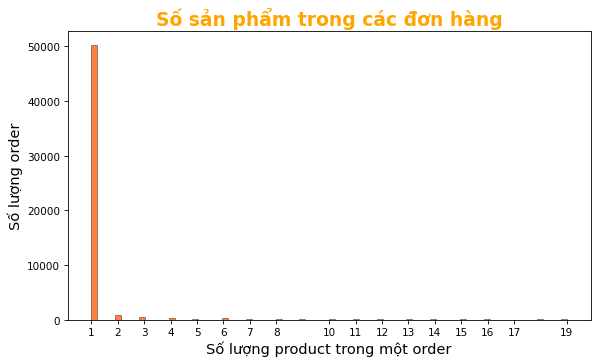

In [24]:
values_order, counts_order = np.unique(data_RATING['order_id'], return_counts= True)
fig,ax = plt.subplots(figsize=(9,5), num=1)
n, bins, edges = ax.hist(counts_order, bins=80,
                             color=colors[0], alpha=.75, edgecolor='black', linewidth=0.5)
# Tạo nhãn trên trục x:
ax.set_title('Số sản phẩm trong các đơn hàng',fontsize=18, color='orange',weight='bold')
ax.set_xticks([int(bins[i]) for i in range(0, bins.size,5)])
ax.set_xlabel("Số lượng product trong một order", fontsize=14)
ax.set_ylabel("Số lượng order", fontsize=14)

plt.show()

### Các sp thường được mua cùng nhau

In [25]:
df_dup1 = data_RATING[data_RATING['order_id'].duplicated(keep=False)]
df_dup1 = pd.merge(df_dup1[["item_id",'order_id']], data_ID[["item_id","Tên"]], on="item_id").sort_values("Tên")
df_dup1['all_pro']=df_dup1.groupby('order_id')["Tên"].transform(' -|- '.join)
df_dup1[['order_id','all_pro']].drop_duplicates()
df_dup1["all_pro"].value_counts().head(1)

điện Thoại Samsung Galaxy A20 Chính Hãng, máy 2sim ram 3G rom 32G, camera siêu nét -|- điện thoại Samsung A40 2sim ram 4G rom 64G Chính Hãng, Chiến Free/PUBG/Liên Quân đỉnh -|- điện thoại Samsung Galaxy A10S Chính Hãng, 2sim ram 3G Bộ nhớ 32G, Camera nét căng, Chiến Free/PUBG/Liên Quân đỉnh -|- điện thoại Samsung Galaxy A10s 2sim ram 3G/32G, màn hình 6.2inch, Cày Game nặng đỉnh chất -|- điện thoại Samsung Galaxy A20 2sim Chính Hãng, ram 3G rom 32G, Làm Tiktok Youtube FB Zalo chất -|- điện thoại Samsung Galaxy A20 2sim ram 3G rom 32G Chính Hãng, Cày Free/PUBG/Liên Quân mượt -|- điện thoại Samsung Galaxy A20E 2sim bộ nhớ 32G ram 3G, Máy Chính Hãng, Camera siêu nét -|- điện thoại Samsung Galaxy A20e - Samsung A20 E 2sim ram 3G/32G, máy Chính Hãng, Chiến PUBG/Free/Liên Quân đỉnh -|- điện thoại Samsung Galaxy A20s 2sim ram 4G rom 64G mới Chính Hãng, màn 6.5inch, Cày Game nặng chất -|- điện thoại Samsung Galaxy A20s Chính Hãng, 2sim ram 4G rom 64G, Cân mọi Game nặng chất -|- điện thoại Samsu

## Tương quan

### Tương quan giữ các cột

C:\Users\MapThui\AppData\Local\Temp\ipykernel_2856\1138020110.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



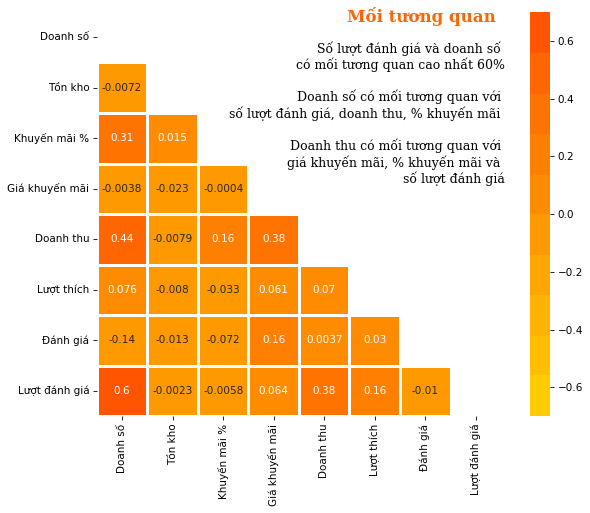

In [26]:
data_test = data_DATA[["Doanh số","Tồn kho","Khuyến mãi %","Giá khuyến mãi",#"Giá gốc",
                       "Doanh thu","Lượt thích","Đánh giá","Lượt đánh giá"]]

corr = data_test.corr()
fig, ax = plt.subplots(figsize=(10, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig.text(.54,.86,'Mối tương quan', fontfamily='serif',fontweight='bold',fontsize=16, color=colors[1])
fig.text(.75,.525,
        '''
         Số lượt đánh giá và doanh số 
         có mối tương quan cao nhất 60%

         Doanh số có mối tương quan với 
         số lượt đánh giá, doanh thu, % khuyến mãi 
         
         Doanh thu có mối tương quan với 
         giá khuyến mãi, % khuyến mãi và 
         số lượt đánh giá
         ''', fontfamily='serif',fontsize=12,ha='right')
pl = sns.heatmap(corr, 
                 mask=mask, 
                 cmap=colors[::-1] , 
                 vmax=0.7, vmin=-.7, center=0, square=True, linewidths=2.5,annot=corr,)

plt.show()

## Mô hình

In [27]:
from sklearn.linear_model import LinearRegression
from scipy import stats
model = LinearRegression()

In [28]:
list_brand = ['Tất cả','Other', 'SAMSUNG', 'nokia', 'LG', 'sony', 'OPPO', 'Xiaomi', 'Vivo','Google', 'hTC', 'Vsmart', 'BlackBerry', 
              'HUAWEI', 'Masstel', 'KYOCERA','motorola', '2Good', 'Apple', 'Mobiistar', 'Realme', 'Sharp', 'TECNO','Itel', 'ulefone',
              'Panasonic', 'OnePlus', 'CAT', 'Meizu', 'LANDROVER','Oukitel', 'Kyocera Torque', 'Asus', 'Fujitsu', 'ADMET', 'AIEK',
              'Black Shark', 'Google Nexus', 'LV Mobile', 'Poco', 'KECHAODA', 'SERVO','GAMMA', 'FORME', 'MAXX', 'Earldom', 'docomo',
              'gor', 'FPT', 'Amazon','SKY', 'Kingston.', 'Viettel', 'Vertu', 'YUNTENG', 'XiaoMi Deerma','aimica', 'GTStar', 'Real']
@widgets.interact(Thương_hiệu = list_brand, Số_mẫu_thử = (1,3058,1))
def Phan_tich_theo_san_bay(Thương_hiệu = "Tất cả" , Số_mẫu_thử = 2800):
    if Thương_hiệu == "Tất cả":
        data = data_DATA.copy()
        ten = "là :"
    else:
        data = data_DATA[data_DATA['brand'] == Thương_hiệu]
        ten = f'của các sản phẩm thuộc thương hiệu {Thương_hiệu} là: '
    
    # Tạo dữ liệu input: dep_delay và distance
    X = np.array(data[['Doanh số', 'Khuyến mãi %','Giá khuyến mãi','Lượt thích','Đánh giá','Lượt đánh giá']])
    # Tạo dữ liệu output: arr_delay
    Y = np.array(data['Doanh thu'])
    # Trộn dữ liệu
    np.random.seed(1)
    rand_indices = np.arange(len(Y))
    np.random.shuffle(rand_indices)
    # Chia dữ liệu làm 2 phần train và test:
    train_indices = rand_indices[0:Số_mẫu_thử]
    test_indices  = rand_indices[Số_mẫu_thử:]
    # Nhập dự liệu train
    x_train=X[train_indices]
    y_train=Y[train_indices]
    # Nhập dự liệu test
    x_test=X[test_indices]
    y_test=Y[test_indices]
    model = LinearRegression()
    model.fit(x_train,y_train)
    coef = model.coef_
    intercept = model.intercept_
    # Hệ số xác định của mô hình train
    r2 = model.score(x_train,y_train)
    # Hệ số xác định của mô hình test
    q2 = model.score(x_test,y_test)
    # Dự đoán toàn bộ tập test
    y_hat = model.predict(x_test)    
    print(f'''
    Tổng số sản phẩm: {len(Y)}
    Số dữ liệu để huấn luyện: {len(train_indices)}
    Số dữ liệu để kiểm tra: {len(test_indices)}   

    Mô hình dự đoán Doanh thu dựa vào Doanh số, Khuyến mãi %, Giá khuyến mãi, Lượt thích, Đánh giá, Lượt đánh giá 
    1 sản phẩm {ten}

    y = {coef[0]:.3f}x1 + {coef[1]:.3f}x2 + {coef[2]:.3f}x3 + {coef[3]:.3f}x4 + {coef[4]:.3f}x5 + {coef[5]:.3f}x6 {intercept:.3f} 
    Với :
    y là Doanh thu
    x1 là Doanh số
    x2 là Khuyến mãi %
    x3 là Giá khuyến mãi
    x4 là Lượt tích
    x5 là Đánh giá
    x6 là Lượt đánh giá
    ''') 
    if r2 > 0.81:
        print(f'    Hệ số xác định của mô hình train là: {r2*100:.2f} % > 81% => Khả năng dự đoán tốt')
    else:
        print(f'    Hệ số xác định của mô hình train là: {r2*100:.2f} % < 81% => Khả năng dự đoán chưa tốt')
    if q2 > 0.81:
        print(f'    Hệ số xác định của mô hình test: {q2*100:.2f} % > 81% => Khả năng dự đoán tốt')
    else:
        print(f'    Hệ số xác định của mô hình test: {q2*100:.2f} % < 81% => Khả năng dự đoán chưa tốt')
    fig = plt.figure(figsize=[12,4])
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.scatter(y_hat,y_test,color='orange')
    ax1.set_title('Phân bố của kết quả mô hình và kết quả thực tế', fontsize=14, fontweight="bold", color="red")
    ax1.set_xlabel(f"y_hat Doanh thu", fontsize=12, color="#FF6600")
    ax1.set_ylabel(f"y_test Doanh thu", fontsize=12, color="#FF6600")
    err = y_hat - y_test
    mean, std = np.mean(err), np.std(err)
    ax2.hist(err,bins=100, density = True,color='orange')
    ax2.set_xlim(mean-4*std, mean+4*std)
    ax2.set_title('Phân bố lỗi và phân bố chuẩn', fontsize=14, fontweight="bold", color="red")
    x = np.linspace(mean-4*std, mean+4*std, 100)
    ax2.plot(x, stats.norm.pdf(x, mean, std), color='red')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Thương_hiệu', options=('Tất cả', 'Other', 'SAMSUNG', 'nokia', 'LG'…

In [29]:
list_brand = ['Tất cả','Other', 'SAMSUNG', 'nokia', 'LG', 'sony', 'OPPO', 'Xiaomi', 'Vivo','Google', 'hTC', 'Vsmart', 'BlackBerry', 
              'HUAWEI', 'Masstel', 'KYOCERA','motorola', '2Good', 'Apple', 'Mobiistar', 'Realme', 'Sharp', 'TECNO','Itel', 'ulefone',
              'Panasonic', 'OnePlus', 'CAT', 'Meizu', 'LANDROVER','Oukitel', 'Kyocera Torque', 'Asus', 'Fujitsu', 'ADMET', 'AIEK',
              'Black Shark', 'Google Nexus', 'LV Mobile', 'Poco', 'KECHAODA', 'SERVO','GAMMA', 'FORME', 'MAXX', 'Earldom', 'docomo',
              'gor', 'FPT', 'Amazon','SKY', 'Kingston.', 'Viettel', 'Vertu', 'YUNTENG', 'XiaoMi Deerma','aimica', 'GTStar', 'Real']
list_MT = ['Doanh thu','Doanh số']
@widgets.interact(Mục_tiêu = list_MT, Thương_hiệu = list_brand, Số_mẫu_thử = (1,3058,1))

def Phan_tich(Mục_tiêu = 'Doanh thu', Thương_hiệu = "Tất cả" , Số_mẫu_thử = 2800):
    if Thương_hiệu == "Tất cả":
        data = data_DATA.copy()
        ten = "là :"
    else:
        data = data_DATA[data_DATA['brand'] == Thương_hiệu]
        ten = f'của các sản phẩm thuộc thương hiệu {Thương_hiệu} là: '
    
    # Tạo dữ liệu input: dep_delay và distance
    X = np.array(data[['Khuyến mãi %','Giá khuyến mãi','Lượt thích','Đánh giá','Lượt đánh giá']])
    # Tạo dữ liệu output: arr_delay
    Y = np.array(data[Mục_tiêu])
    # Trộn dữ liệu
    np.random.seed(1)
    rand_indices = np.arange(len(Y))
    np.random.shuffle(rand_indices)
    # Chia dữ liệu làm 2 phần train và test:
    train_indices = rand_indices[0:Số_mẫu_thử]
    test_indices  = rand_indices[Số_mẫu_thử:]
    # Nhập dự liệu train
    x_train=X[train_indices]
    y_train=Y[train_indices]
    # Nhập dự liệu test
    x_test=X[test_indices]
    y_test=Y[test_indices]
    model = LinearRegression()
    model.fit(x_train,y_train)
    coef = model.coef_
    intercept = model.intercept_
    # Hệ số xác định của mô hình train
    r2 = model.score(x_train,y_train)
    # Hệ số xác định của mô hình test
    q2 = model.score(x_test,y_test)
    # Dự đoán toàn bộ tập test
    y_hat = model.predict(x_test)    
    print(f'''
    Tổng số sản phẩm của Thương hiệu {Thương_hiệu} = {len(Y)}
    Số dữ liệu để huấn luyện: {len(train_indices)}
    Số dữ liệu để kiểm tra: {len(test_indices)}   

    Mô hình dự đoán {Mục_tiêu} dựa vào Khuyến mãi %, Giá khuyến mãi, Lượt thích , Đánh giá, Lượt đánh giá 1 sản phẩm {ten}:
    Mô hình:
    y = ({coef[0]:.3f}x1)+ ({coef[1]:.3f}x2)+ ({coef[2]:.3f}x3)+ ({coef[3]:.3f}x4)+ ({coef[4]:.3f}x5)+ {intercept:.3f} 
    Với :
    y là {Mục_tiêu} 
    x1 là Khuyến mãi %
    x2 là Giá khuyến mãi
    x3 là Lượt thích
    x4 là Đánh giá
    x5 là Lượt đánh giá
    ''') 
    if r2 > 0.81:
        print(f'    Hệ số xác định của mô hình train là: {r2*100:.2f} % > 81% => Khả năng dự đoán tốt')
    else:
        print(f'    Hệ số xác định của mô hình train là: {r2*100:.2f} % < 81% => Khả năng dự đoán chưa tốt')
    if q2 > 0.81:
        print(f'    Hệ số xác định của mô hình test: {q2*100:.2f} % > 81% => Khả năng dự đoán tốt')
    else:
        print(f'    Hệ số xác định của mô hình test: {q2*100:.2f} % < 81% => Khả năng dự đoán chưa tốt')
    fig = plt.figure(figsize=[12,4])
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.scatter(y_hat,y_test,color="orange")
    ax1.set_title('Phân bố của kết quả mô hình và kết quả thực tế', fontsize=14, fontweight="bold", color="red")
    ax1.set_xlabel(f"y_hat {Mục_tiêu}", fontsize=12, color="blue")
    ax1.set_ylabel(f"y_test {Mục_tiêu}", fontsize=12, color="green")
    err = y_hat - y_test
    mean, std = np.mean(err), np.std(err)
    ax2.hist(err,bins=100, density = True, color="orange")
    ax2.set_xlim(mean-4*std, mean+4*std)
    ax2.set_title('Phân bố lỗi và phân bố chuẩn', fontsize=14, fontweight="bold", color="red")
    x = np.linspace(mean-4*std, mean+4*std, 100)
    ax2.plot(x, stats.norm.pdf(x, mean, std), color='red')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Mục_tiêu', options=('Doanh thu', 'Doanh số'), value='Doanh thu'), …

In [30]:
fig = px.sunburst(data_cus_9, path=['user_name','brand'], values='item_id',color='item_id',
                  color_continuous_scale=colors[::-4],
                  labels={'item_id':"Số sản phẩm",},
                  width=700, height=500)  
fig.update_layout(title="Top 5 khách hàng mua hàng nhiều nhất",
                   title_font_color='orange',
                   title_font_size=20,
                   title_font_family="Times New Roman",
                  )
fig.update_layout(margin = dict(t=50, l=10, r=10, b=25))
fig.update_traces(textinfo='value+label',
                  hoverinfo='value+label',
                  hovertemplate ="%{label} <br>Số lượng shop: %{value}",
                  textfont_size=13,
                 )
fig.show()

### Tỉ lệ Doanh số, Tồn kho, Doanh thu, theo Khu vực, Khuyến mãi

In [47]:
data_ti_le_1 = data_DATA[['item_id','brand',"Doanh số","Tồn kho","Khuyến mãi %","Giá khuyến mãi",
                       "Doanh thu","Lượt thích","Đánh giá","Lượt đánh giá"]]
data_ti_le_2 = pd.merge(data_ti_le_1, data_ID[["item_id","Tỉnh"]], on="item_id")
data_ti_le_3 = pd.merge(data_ti_le_2, data_LOC[["Tỉnh","Khu Vực"]], on="Tỉnh")
data_ti_le_4 = data_ti_le_3.reset_index()
Khuyen_mai_1 = pd.Series(['Không'] *data_ti_le_4['Khuyến mãi %'].size)
Khuyen_mai_1[data_ti_le_4['Khuyến mãi %'] > 0] = 'Có'
data_ti_le_4['Khuyến mãi'] = Khuyen_mai_1
data_ti_le_4 = data_ti_le_4.rename(columns = {"brand":"Thương hiệu"})
data_ti_le_4['Doanh thu (Tỷ VNĐ)'] = data_ti_le_4['Doanh thu']/1000000000

list_name = ['Doanh số', 'Tồn kho','Doanh thu (Tỷ VNĐ)', 'Lượt thích', 'Lượt đánh giá']
list_class = ['Khuyến mãi',"Tỉnh","Khu Vực","Thương hiệu"]
@widgets.interact(Mục_tiêu=list_name, Phân_loại = list_class)
def Doanh_thu_theo_thuong_hieu_1(Mục_tiêu='Doanh thu (Tỷ VNĐ)',Phân_loại = 'Khuyến mãi'):

    fig = px.pie(data_ti_le_4,values=Mục_tiêu, names=Phân_loại,
                 #color_discrete_sequence=px.colors.sequential.Oranges,
                 width=400, height=400,
                 #labels={'labels':"Tên","Số lượng shop_sum":'Tổng số shop'},
                )    
    fig.update_layout(title=f"Tỉ lệ {Mục_tiêu.lower()} theo {Phân_loại.lower()}",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                     )
    fig.update_layout(margin = dict(t=50, l=0, r=0, b=25))
    fig.update_traces(textposition='inside', textinfo='percent+value+label', hoverinfo='label+percent',
                      hovertemplate ="%{label} <br>%{value}",
                      textfont_size=16,pull=[0.1, 0],
                      marker=dict(colors=colors[::]))
    fig.show()

interactive(children=(Dropdown(description='Mục_tiêu', index=2, options=('Doanh số', 'Tồn kho', 'Doanh thu (Tỷ…

### Sử dụng interact tương quan giữa các cột

In [32]:
data_test_1 = data_DATA[['item_id','brand',"Doanh số","Tồn kho","Khuyến mãi %","Giá khuyến mãi",
                       "Doanh thu","Lượt thích","Đánh giá","Lượt đánh giá"]]
data_test_2 = pd.merge(data_test_1, data_ID[["item_id","Tỉnh"]], on="item_id")
data_test_3 = pd.merge(data_test_2, data_LOC[["Tỉnh","Khu Vực"]], on="Tỉnh")
data_test_4 = data_test_3.reset_index()
Khuyen_mai = pd.Series(['Không'] *data_test_4['Khuyến mãi %'].size)
Khuyen_mai[data_test_4['Khuyến mãi %'] > 0] = 'Có'
data_test_4['Khuyến mãi'] = Khuyen_mai 
data_test_4 = data_test_4.rename(columns = {"brand":"Thương hiệu"})

list_x = ["Doanh số","Tồn kho","Giá khuyến mãi", "Doanh thu","Lượt thích","Lượt đánh giá"]
list_y = ["Doanh số","Tồn kho","Giá khuyến mãi", "Doanh thu","Lượt thích","Lượt đánh giá"]
list_size = ["Doanh số","Tồn kho","Giá khuyến mãi", "Doanh thu","Lượt thích","Lượt đánh giá",None]
list_class = ["Tỉnh","Khu Vực",'Khuyến mãi',"Thương hiệu",None]

@widgets.interact(Trục_X = list_x, Trục_Y=list_y, Kích_thước=list_size, Phân_loại= list_class, Trendline= True, Độ_tin_cậy_95 = True )
def Tuong_quan(Trục_X ="Lượt đánh giá",Trục_Y ="Doanh số",Kích_thước ="Doanh thu", Phân_loại ="Khu Vực",Trendline='ols',Độ_tin_cậy_95 = True):
    if Trendline == True:
        A = 'ols'
    else:
        A = None
        
    if Độ_tin_cậy_95 == True: 
        CI_95_X = np.percentile(np.array(data_test_4[Trục_X]),[2.5,97.5])
        data_test_5 = data_test_4[data_test_4[Trục_X]>CI_95_X[0]]
        data_test_6 = data_test_5[data_test_5[Trục_X]<CI_95_X[1]]
        
        CI_95_Y = np.percentile(np.array(data_test_4[Trục_Y]),[2.5,97.5])
        data_test_7 = data_test_6[data_test_6[Trục_Y]>CI_95_Y[0]]
        data_test_8 = data_test_7[data_test_7[Trục_Y]<CI_95_Y[1]]
        data = data_test_8      
    else:
        data = data_test_4 
   
    fig = px.scatter(data,x = Trục_X, y = Trục_Y, size = Kích_thước,
                 color = Phân_loại,marginal_x="histogram", marginal_y="box",
                 trendline = A, 
                     #color_discrete_sequence=['#FF5500',"blue","green"]
                )
    fig.update_layout(title=f"Mối tương quan giữa {Trục_X} và {Trục_Y}",
                      title_font_color='orange',
                      title_font_size=20,
                      title_font_family="Times New Roman",
                      xaxis_title=f"{Trục_X}",
                      yaxis_title=f"{Trục_Y}",
                     )
    fig.show()


interactive(children=(Dropdown(description='Trục_X', index=5, options=('Doanh số', 'Tồn kho', 'Giá khuyến mãi'…

## Tạo wordcloud

### Wordclod về các mức độ quan tâm đến thương hiệu

In [33]:
# data_wc = pd.merge(data_DATA[["item_id",'brand']], data_RATING[["item_id","Bình luận"]], on="item_id")

# text = " ".join(cat for cat in data_wc.brand)

# stopwords = set(STOPWORDS)

# # Read and convert an mask image. It should have a white (not transparent) background with a black object.
# #mask_img = np.array(Image.open("ncBMAnRei.jpg"))
# cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# wordcloud = WordCloud(background_color="#FFFFFF",
#                       max_words=100, 
#                       #mask=mask_img,
#                       width=3000,
#                       height=2000,
#                       random_state=2,
#                       colormap=cmap1,
#                       collocations=False,
#                       stopwords=STOPWORDS
#                       ).generate(text)

# # store to file
# #wordcloud.to_file("wc.png")

# # Show the image
# plt.figure(figsize=(10,10))
# plt.tight_layout(pad=0)
# plt.axis("off")
# plt.imshow(wordcloud, interpolation='bilinear')

(-0.5, 4999.5, 4999.5, -0.5)

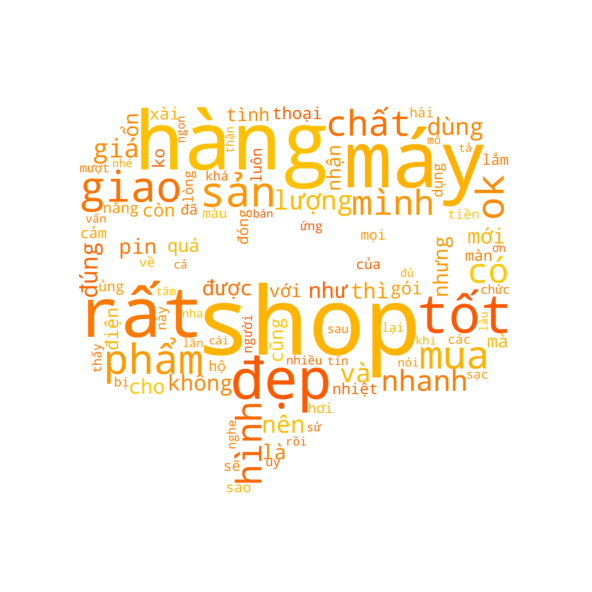

In [34]:
data_RATING['Bình luận'] = data_RATING['Bình luận'].astype(str)
text_cmt = " ".join(review for review in data_RATING['Bình luận'])
mask_img = np.array(Image.open("comment.jpg"))

stopwords_1 = set(STOPWORDS)
stopwords_1.update(["nan",])

# Read and convert an mask image. It should have a white (not transparent) background with a black object.
#mask_img = np.array(Image.open("pngtree-red-heart-icon-isolated-png-image_1726594.jpg"))
wordcloud = WordCloud(background_color="#FFFFFF", 
                      max_words=100, 
                      mask=mask_img,
                      width=3000,
                      height=2000,
                      random_state=1,
                      colormap=cmap1,
                      collocations=False,
                      stopwords=stopwords_1
                      ).generate(text_cmt)
# store to file
#wordcloud.to_file("wc.png")
plt.figure(figsize=(10,10))
plt.tight_layout(pad=0)

# Show the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

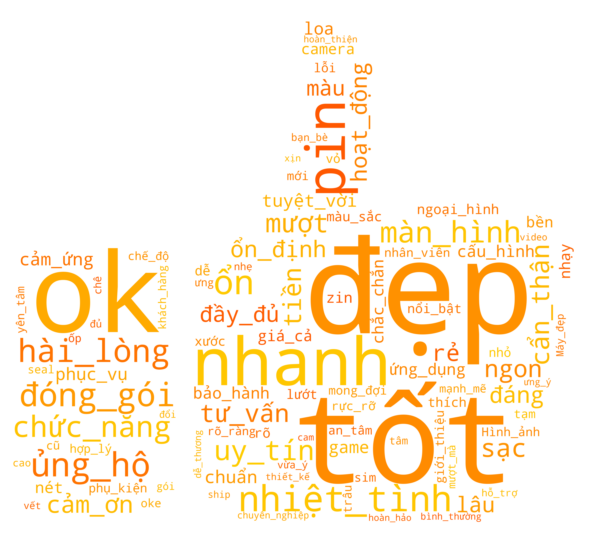

In [35]:
data_cmt = data_RATING.copy()
data_cmt.dropna(inplace=True, axis=0, how="any")
data_cmt_1 = data_cmt.reset_index()
text_cmt_like = " ".join(review for review in data_cmt_1[data_cmt_1["Rank"]=="Cao nhất"]['VAN'])
mask_img = np.array(Image.open("like1.jpg"))

stopwords_2 = set(STOPWORDS)
stopwords_2.update(["shop", "máy","hàng","nan",'mua','giao',"ko",'có',"dùng","nha","đc","còn","sau","ạ",'là',"bị","hẹn","lưng","màn","em",
                   "sản_phẩm", "chất_lượng","điện_thoại","ngày","nhiều","thứ","biết",'chạy','bán','thêm','qua','nói',"về",'gần','độ',
                   'khi','đặt', 'tầm','sáng','lần','mạng','hơn','bên','hơi','đt','phải',"xem",'gọi',"Sản_phẩm",'khác','sp','chụp','sài',
                   "người",'lên',"nghe",'mang',"thấy","hết","quảng_cáo","nhận",'làm',"xu","nhìn","nguyên",'gửi',"thời_gian","tặng",''
                   "sao","chơi",'ảnh',"hãng",'tay','mô_tả','đánh_giá','Tính_năng',"hình","chúc", 'cầm',"hiện_tại",'xài','tiếp',"kèm"
                    'đồng_tiền','dán','dc','sử_dụng','nhé','may','bạn','hộp',"bảo",'ra','đi','mong','cục','mặt','nhắn','lúc','chủ',"hôm",
                    'vào','thôi','hỏi','khách','tin',"nt",'tính_chất','đồng_tiền',"ngoài",'trong','xong','giống','điểm','mn','kêu',
                    'cho','ít','web',"đen",'xanh','vàng','anh_em','người_thân','cơ_bản','tiếng','điện','thay','kiểu','dt','con','muốn',
                    'cái','đâu','vô','báo','trước','được','đầu','thèm','cắm','số','mở','nên','chỗ','trắng','số','sóng','lắp','đầy',"v",
                    'j','chỗ','bắt','kèm','bấm','lấy','giờ','chắc','cần','hồng','tuần','coi','chân','góc','chịu','nắp','mau','ăn','ae',
                    'giá','đúng','thử',"test"
                   ])
wordcloud = WordCloud(background_color="#FFFFFF", max_words=100, 
                      mask=mask_img,
                      width=3000,
                      height=2000,
                      random_state=1,
                      colormap=cmap1,
                      collocations=False,
                      stopwords=stopwords_2
                      ).generate(text_cmt_like)
plt.figure(figsize=(10,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

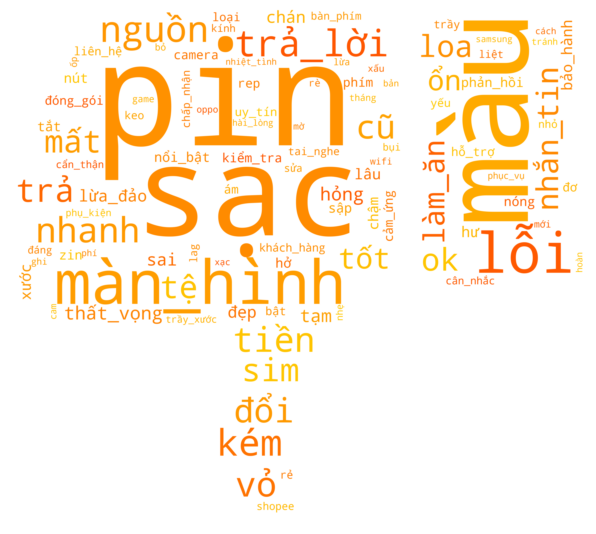

In [36]:
text_cmt_dislike = " ".join(review for review in data_cmt_1[data_cmt_1["Rank"]=="Thấp nhất"]['VAN'])
mask_img = np.array(Image.open("dislike1.jpg"))

stopwords_3 = set(STOPWORDS)
stopwords_3.update(["shop", "máy","hàng","nan",'mua','giao',"ko",'có',"dùng","nha","đc","còn","sau","ạ",'là',"bị","hẹn","lưng","màn","em",
                   "sản_phẩm", "chất_lượng","điện_thoại","ngày","nhiều","thứ","biết",'chạy','bán','thêm','qua','nói',"về",'gần','độ',
                   'khi','đặt', 'tầm','sáng','lần','mạng','hơn','bên','hơi','đt','phải',"xem",'gọi',"Sản_phẩm",'khác','sp','chụp','sài',
                   "người",'lên',"nghe",'mang',"thấy","hết","quảng_cáo","nhận",'làm',"xu","nhìn","nguyên",'gửi',"thời_gian","tặng",''
                   "sao","chơi",'ảnh',"hãng",'tay','mô_tả','đánh_giá','Tính_năng',"hình","chúc", 'cầm',"hiện_tại",'xài','tiếp',"kèm"
                    'đồng_tiền','dán','dc','sử_dụng','nhé','may','bạn','hộp',"bảo",'ra','đi','mong','cục','mặt','nhắn','lúc','chủ',"hôm",
                    'vào','thôi','hỏi','khách','tin',"nt",'tính_chất','đồng_tiền',"ngoài",'trong','xong','giống','điểm','mn','kêu',
                    'cho','ít','web',"đen",'xanh','vàng','anh_em','người_thân','cơ_bản','tiếng','điện','thay','kiểu','dt','con','muốn',
                    'cái','đâu','vô','báo','trước','được','đầu','thèm','cắm','số','mở','nên','chỗ','trắng','số','sóng','lắp','đầy',"v",
                    'j','chỗ','bắt','kèm','bấm','lấy','giờ','chắc','cần','hồng','tuần','coi','chân','góc','chịu','nắp','mau','ăn','ae',
                    'giá','đúng','thử',"test"
                   ])
wordcloud = WordCloud(background_color="#FFFFFF", max_words=100, 
                      mask=mask_img,
                      width=3000,
                      height=2000,
                      random_state=1,
                      colormap=cmap1,
                      collocations=False,
                      stopwords=stopwords_3
                      ).generate(text_cmt_dislike)
plt.figure(figsize=(10,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()